# Quantum Variational Simulator

## Summary

The usual method to simulate quantum evolution in quantum systems is using the Trotter expansion. However, this usually requires circuits with many quantum operations and a large depth, which is not desirable in the current noisy era of quantum computation. An alternative is to use Variational Quantum Simulation, since the depth of the circuit is fixed during all the computation and we can choose variational forms that are efficient for different hardwares. 

In this project, we implement a Python package that, given a Hamiltonian, a variational form and a state at $t=0$, gives us the state of the system for a future state at time $t = T$ using a variational method. In the tutorial, we present the theory of variational quantum simulation and continue with the details of our implementation using Qiskit. Then, we show simulations for the evolution of quantum Isings models of 2 and 3 qubits and compare with experimental realizations using IBM's quantum processors and Qiskit Runtime. The results show an excellent agreement between theory and experiment.

## 1. Introduction

The problem of simulating quantum many-body systems is well-known to be extremely challenging for classical computers. This is due to the exponential dimension of the associated Hilbert space. For these systems, it is impossible to diagonalize the Hamiltonian to find the ground state energy, or to solve the Schrödinger equation to obtain its time evolution. Variational Classical Simulation (VCE) $[$[1](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)), [5](https://www.sciencedirect.com/science/article/abs/pii/0003491688902801?via%3Dihub), [6](https://doi.org/10.1103/PhysRevLett.107.070601)$]$ is an alternative to these direct methods because effectively reduces the dimension of systems using efficient classical representations. It can be used to find the ground state energy and to simulate time evolution of quantum systems. However, for highly-entangled systems VQE is usually infeasible, because there are not good classical representations of these states. 

The efficient alternative is using quantum systems to simulate quantum systems. The Trotterization technique is the usual method to perform quantum evolution, and approximates the time evolution under a Hamiltonian $H = \sum_j H_j$ from $0$ to $T$ by

$$
e^{-i H T} \approx   \left( \prod_j e^{-i H_j \Delta t}\right)^N,
$$

where $e^{-i H_j \Delta t}$ is the unitary generated by $H_j$ for a short time $\Delta t = T/N$. Variational Quantum Algorithms (VQA) are the quantum version of VCE and they can be used to find the ground state energy of relevant Hamiltonians using efficient variational forms and classical optimization. These algorithms can also be used as an alternative for Trotterization, that usually requires circuits with many quantum operations and a large depth. This is not desirable in the current era of quantum computation, because quantum processors are still noisy and the depth of the circuits is restricted by the decoherence time of the system. For VQA, the depth of the circuit is fixed during all the computation and we can choose variational forms that are efficient for different hardwares.

In this project, we present a Python package that, given a Hamiltonian, a variational form and a state at $t=0$, gives us the state of the system for a future state at time $t = T$ using the variational method presented in the paper [Efficient Variational Quantum Simulator Incorporating Active Error Minimization](https://doi.org/10.1103/PhysRevX.7.021050). We start this tutorial with the theory of variational quantum simulation and continue with the details of our implementation using Qiskit. Then, we show simulations for the evolution of quantum Isings models of 2 and 3 qubits and compare with experimental realizations using IBM's quantum processors and Qiskit Runtime. Finally, we discuss our results and propose future improvements of the package.

## 2. The time-dependent variational principle

This a variational principle that, when applied to a system, yields the equations of motion for that system $[$[2](https://en.wikipedia.org/wiki/Stationary-action_principle)$]$. It is given by

$$\delta \int_{t_{i}}^{t_{f}} dt L=0,$$

where in the case of the Schrödinger equation the Lagrangian is $L=\langle\Psi(t)|\left(i \frac{\partial}{\partial t}-H\right)| \Psi(t)\rangle$. Now, we assume that the state $| \Psi(t)\rangle$ is determined by a set of real parameters $\left\{\lambda_{k}(t)\right\}$, that is $|\Psi(t)\rangle \equiv\left|\Psi\left(\lambda_{1}, \lambda_{2}, ..., \lambda_{N}\right)\right\rangle$. We want to obtain differential equations for the evolution of the system as a function of these parameters. The Lagrangian can be rewritten as 

$$
L=i \sum_{k}\langle\Psi| \frac{\partial|\Psi\rangle}{\partial \lambda_{k}} \dot{\lambda}_{k}-\langle\Psi|H| \Psi\rangle
$$

which is a function of parameters $\{\lambda_{k}\}$ and their time derivatives $\left\{\dot{\lambda}_{k}=\left[d \lambda_{k} / d t\right]\right\}$. After applying the [Euler-Lagrange equations](https://en.wikipedia.org/wiki/Euler–Lagrange_equation#Statement), the evolution of the parameters is given by

$$
\sum_{q} M_{k, q} \dot{\lambda}_{q}=V_{k}
$$

where

$$
M_{k, q}=i  \frac{\partial\langle\Psi|}{\partial \lambda_{k}} \frac{\partial|\Psi\rangle}{\partial \lambda_{q}}+\text { H.c. } \quad \text{and} \quad V_{k}= \frac{\partial\langle\Psi|}{\partial \lambda_{k}} H|\Psi\rangle+\text { H.c. }
$$

We now suppose that we know all the coefficients $M_{k, q}$ and $V_{k}$ for all times. Then, given an initial state $|\Psi(0)\rangle \equiv\left|\Psi\left(\lambda_{1} (0), \lambda_{2} (0), ..., \lambda_{N} (0)\right)\right\rangle$, we can solve the equations for $\{ \dot{\lambda}_k \}$ to find the parameters $\{ \lambda_{k} \}$ at a given time $T$, and then, the evolved state $|\Psi(T)\rangle \equiv\left|\Psi\left(\lambda_{1} (T), \lambda_{2} (T), ..., \lambda_{N} (T)\right)\right\rangle$.

## 3. Variational algorithm on a hybrid computer

The variational method avoids the exponential space problem that classical methods have by considering trial states from a physically motivated small subset of the exponentially large Hilbert space. Here we consider trial states that can be directly prepared in the quantum computer; i.e., states can be expressed as $|\Psi\rangle=R|\overline{0}\rangle$, where $|\overline{0}\rangle$ is an initial state of the quantum computer and $R$ is a sequence of $N$ quantum gates determined by parameters $\left\{\lambda_{k}\right\}$, that is

$$
R=R_{N}\left(\lambda_{N}\right) \ldots R_{k}\left(\lambda_{k}\right) \ldots R_{1}\left(\lambda_{1}\right).
$$

<!-- If N is smaller than the dimension of the Hilbert space, trial states $|\Psi\rangle$ only span a submanifold of the Hilbert space. Therefore, Eq.\eqref{main} approximates -->
In conventional quantum computing, each unitary gate involves a small subset of qubits, typically one or two. Thefore, the derivative of the unitary $R_k =  \exp \left(\lambda_k {\sum_{i} f_{k, i} \sigma_{k, i}} \right)$ can be efficiently decomposed via 

$$
\frac{d R_{k}}{d \lambda_{k}}=\sum_{i} f_{k, i} R_{k} \sigma_{k, i},
$$

where $\sigma_{k, i}$ are also unitary operators and $f_{k, i}$ are complex coefficients. For most single- and two-qubit gates $R_{k}$, we find that there are only one or two terms in this expression, and $\sigma_{k, i}$ is also a one-qubit or two-qubit gate. 

<details>
    <summary>Click to Expand: Example</summary>
For the case when 
$$
R_{k}(\lambda_{k})=e^{-i \lambda_{k} \sigma / 2},$$ 
with a one- or two-qubit Hermitian operator $\sigma$, we have
$$
\frac{\partial R_{k}(\lambda_{k})}{\partial \lambda_{k}}=-\frac{i}{2} \cdot \sigma \cdot e^{-i \lambda_{k} \sigma / 2},
$$
where $f_{k}=-i / 2$ and $\sigma_{k}=\sigma$.
</details>


With the definition of the trial state we can rewrite the derivative of the state as

$$
\frac{\partial|\Psi\rangle}{\partial \lambda_{k}}=\sum_{i} f_{k, i} R_{k, i}|\overline{0}\rangle,
$$

where
$$
R_{k, i}=R_{N} R_{N-1} \cdots R_{k+1} R_{k} \sigma_{k, i} \cdots R_{2} R_{1}.
$$

Then, based on the definition of the Hamiltonian, the elements of $M$ and $V$ can be expressed as

$$
M_{k, q}=\sum_{i, j}i\left(f_{k, i}^{*} f_{q, j}\langle\overline{0}|R_{k, i}^{\dagger} R_{q, j}| \overline{0}\rangle\right) \quad \text{and} \quad V_{k}=\sum_{i, j}\left(f_{k, i}^{*} h_{j}\langle\overline{0}|R_{k, i}^{\dagger} \sigma_{j} R| \overline{0}\rangle\right).
$$

Note that each term is in the form $a \operatorname{Re}(e^{i \theta}\langle\overline{0}|U| \overline{0}\rangle)$ where the amplitude $a$ and phase $\theta$ are determined by either $i f_{k, i}^{*} f_{q, j}$ or $f_{k, i}^{*} h_{j}$, and $U$ is a unitary operator equal to either $R_{k, i}^{\dagger} R_{q, j}$ or $R_{k, i}^{\dagger} \sigma_{j} R$. Such a term can be evaluated using the following quantum circuit

<img src="img/circuit.png" alt="Drawing" style="width: 600px;"/>
<font size="2"><center> Figure extracted from the paper "Theory of variational quantum simulation" [8] </center> <font size="5"></font>

This circuit needs an ancillary qubit initialized in the state $\left(|0\rangle+e^{i \theta}|1\rangle\right) / \sqrt{2}$ and a register initialized in the state $|\overline{0}\rangle$. The ancillary qubit is measured in the $\{|+\rangle,|-\rangle\}$ basis after a sequence of quantum gates on the register and two controlled gates, in which the ancillary qubit is the control qubit. The value of each term is given by $\operatorname{Re}(e^{i \theta}\langle\overline{0}|U| \overline{0}\rangle)= 2P_{+} - 1$, where $P_{+}$ is the probability that the qubit is in the state $| + \rangle$.

## 4. Implementation using Qiskit

### 4.1 Introduction

The Variational Quantum Simulation theory allows to describe the time evolution of a parameterized state $ |\Psi(t)\rangle = |\Psi (\{\lambda_i(t)\}_{i=1}^N) \rangle$ through the ordinary differential equation (ODE),
$$ \frac{d\lambda_i}{dt} = \left[M^{-1}\right]_{ik} V_k $$
where the matrix $M$ and the vector $V$ can be computed by means of the Hamiltonian of the system, and a quantum circuit, as presented on Sec. 2.

In this spirit, we implemented a python library which can solve this ODE by computing the relevant quantities on a real quantum device provided by IBM through Qiskit, and perform a fully working simulation for a quantum system of interest. 

To accomplish this goal, the library which we named `VarQuS`, is organized as follows
```
 varqus
   └─── ode.py
   └─── variational_simulation.py
   └─── analytic.py
   └─── integrators.py
   └─── states.py
   └─── utils.py
```

### 4.2 Define a problem

In the following, we will briefly describe each part of the library, but in order to give exemples as we go through it, we will begin by defining a system to solve

In [1]:
import numpy as np

# Circuit information
circuit_coefs     = [[-0.5j], [-0.5j, -0.5j]]
circuit_operators = [["ZZ"],  [ "XI",  "IX"]]

# System information
hamiltonian_coefs     = [-0.5, -0.5, -0.5]
hamiltonian_operators = ["ZZ", "XI",  "IX"]

# Initial state and parameters
initial_state  = np.ones(4, dtype=complex)/2
initial_params = np.array([1.0, 1.0])

Note that a time-dependent Hamiltonian could also be provided, for example, with coefficients:
```python
hamiltonian_coefs = lambda t: [0.5*np.sin(t), 2.0*np.cos(t)]
```

### 4.3 ODE
The first file, named `ode.py` provides an interface for the final user, a function called `define_vqs_ode`, which takes the information of the circuit and the Hamiltonian of the system, and defines another function, representing the ODE to solve, which can be evaluated for a group of parameters, $\lambda_i(t_n)$ and its corresponding time, $t_n$, to obtain $d\lambda_i/dt$.

In [2]:
from varqus.ode import define_vqs_ode

vqs_analytic  = define_vqs_ode(circuit_operators, hamiltonian_operators, circuit_coefs, hamiltonian_coefs, initial_state, backend='analytic')
vqs_simulated = define_vqs_ode(circuit_operators, hamiltonian_operators, circuit_coefs, hamiltonian_coefs, initial_state, shots=2**13)

Note that this function takes a keyword `backend`, which accepts a qiskit backend and defaults to the Qiskit Aer simulator, but can be changed to run on a real quantum device. If `backend='analytic'` is passed, then the system is solved exactly by means of linear algebra operations instead of running in a backend. For any backend different to `'analytic'`, the number of shots must be provided with the `shots` keyword.

Similarly, `ode.py` also provides a function called `define_schrodinger_ode` which takes the information of the system and defines an ODE, corresponding to the time-dependent Schrodinger equation.

In [3]:
from varqus.ode import define_schrodinger_ode

schrodinger_ode = define_schrodinger_ode(hamiltonian_operators, hamiltonian_coefs)

### 4.4 Variational simulation

The file `variational_simulation.py` provides all the methods required to calculate the matrix `M` and the vector `V` in a quantum circuit. This tools are managed internally by the ODE defined, and therefore, they are not of interest for the final user.

### 4.5 Analytic

The file `analytic.py` provides the methods to calculate `M` and `V` analytically. That is, the Variational Quantum Simulation theory is used and the equations are directly solved, instead of running them in a backend. Just like `variational_simulation.py`, the methods defined on this file are not of interest for the final user.

### 4.6 Integrators

The file `integrators.py` provide integrators which can take the ODEs previously defined and solve it for some time span. As of now, two integrators are implemented: the first order `euler` and the forth order Runge-Kutta `rk4`. Both integrators accept the same arguments.

In [4]:
# Set time discretization
dt = 0.01 # time step
Nt = 10   # number of time steps

from varqus.integrators import euler, rk4

# Here we solve the previously posed ODE's
vqs_analytic_evolved  = euler(vqs_analytic,  initial_params, dt, Nt)
vqs_simulated_evolved = euler(vqs_simulated, initial_params, dt, Nt)

### 4.7 States
The file `states.py` provides some basic tools to work on states. They are useful to the end user.

In [5]:
from varqus.states import state_from_parameters, state_infidelity

# We want to compare the simulated evolution with the states obtained from solving the Schrodinger equation.
# For this we will first build the 'trial' state, that is, the state corresponding to the initial parameters,
# which we will recover with the 'state_from_parameters' function.
trial_state = state_from_parameters(initial_params, circuit_operators, circuit_coefs, initial_state)

# And then we solve the Schrodinger ODE starting from the trial state
# (Remember the Schrodinger equation acts over the state, not the parameters)
schrodinger_evolved = euler(schrodinger_ode, trial_state, dt, Nt)


# We also recover the states from the VQS simulations
# Run in the Qiskit simulator
simulated_states = np.array([state_from_parameters(params, circuit_operators, circuit_coefs, initial_state)
                             for params in vqs_simulated_evolved])

# The state infidelity is a distance measure between states. If both states are similar, its infidelity will be close to zero.
vqs_infidelities = [state_infidelity(simulated_states[t], schrodinger_evolved[t]) for t in range(Nt)]

print(f"The maximum infidelity between the states evolved with VQS and")
print(f"the ones evolved by solving the Schrodinger equations is: {max(vqs_infidelities)}")

The maximum infidelity between the states evolved with VQS and
the ones evolved by solving the Schrodinger equations is: 1.9644760607118172e-07


### 4.8 Utils

The file `utils.py` provides utilities needed by the rest of the library, for example, to parse the matrix form of the operator from their name. This file is of no interest to the final user.

## 5. Variational Quantum Simulations for the 2 qubits quantum Ising model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from varqus.ode import define_vqs_ode, define_schrodinger_ode
from varqus.integrators import euler
from varqus.states import state_from_parameters, state_infidelity

Following $[$[8](https://doi.org/10.1103/PhysRevLett.107.070601)$]$, we test our variational algorith for the quantum Ising model $[$[3](https://en.wikipedia.org/wiki/Ising_model)$]$. The Hamiltonian of the model is given by:

$$
H = H_{z} + H_{x} = -J \sum_{j=1}^{n_{\mathrm{s}}} \sigma_{j}^{\mathrm{z}} \sigma_{j+1}^{\mathrm{z}} - B\sum_{j=1}^{n_{\mathrm{s}}} \sigma_{j}^{\mathrm{x}}
$$

where $n_s$ is the number of spins, $J$ is the interaction between nearest neighbours spins and $B$ is an external magnetic field. The operators $\sigma^{x}_{j}$ and $\sigma^{z}_{j}$ are the $X$ and $Z$ Pauli operators acting on the $j$ site, and every pair is counted once. For the 2 spins case $n_{s}=2$, and taking the constants $J=B=\frac{1}{2}$, the Hamiltonian becomes:

$$
H = H_{z} + H_{x} = -\frac{1}{2} \left( ZZ\right) -\frac{1}{2} \left(XI + IX \right)
$$

The trial state $|\Psi\rangle$ for the hybrid algorithm is

$$
|\Psi (\lambda_1, \lambda_2) \rangle = R(\lambda_1, \lambda_2) |\Phi(0)\rangle = e^{i \lambda_{1} H_{x}} e^{i \lambda_{2} H_{z}} |\Phi(0)\rangle
$$

where $R(\lambda_1, \lambda_2)$ is a sequence of quantum gates determined by parameters $(\lambda_1, \lambda_2)$ and the initial state $|\Phi(0)\rangle$ is a one-dimensional cluster state given by

$$
|\Phi(0)\rangle = H_{1} H_{2} |00\rangle = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle  \right)
$$

where $H_i$ is the Hadamard gates acting on the $i$-th qubit.

First, we define the proper parameters and operators to construct the Hamiltonian $H$, the trial state $|\Psi\rangle$ and the initial state $|\Phi(0)\rangle$. 

In [7]:
J = 1/2
B = 1/2

# Hamiltonian parameters and operators

hs = [-J, -B, -B]
opsH = ["ZZ", "XI", "IX"]

# Rotations parameters and operators

fs = [[-1j*J], [-1j*B, -1j*B]]
ops = [["ZZ"], ["XI", "IX"]]

# Initial state

ini_state = np.ones(4, dtype=complex)/2

Then, we fix the time step $\delta t$, the number of steps $N_t$ and the initial parameters $\lambda_{1}(0), \lambda_{2}(0)$ for the trial state

In [8]:
# Time discretization and initial parameters for the trial state

params_init = np.array([1.0, 1.0])
dt = 0.01
Nt = 100

Now, we execute our algorithm, first defining the ordinary diferential equation using the variational quantum simulator, and then solving it using a numerical Euler's method, to obtain the parameters in a posterior time $\left\{\lambda_{k}\left(t_{n}\right)\right\}$.

In [9]:
# Define the ode as a function of the parameters

# ode = define_vqs_ode(ops, opsH, fs, hs, ini_state, shots=2**13)

# # Integrate in time using Euler's method
# lambda_k_t = euler(ode, params_init, dt, Nt)

In [10]:
# If you don't want to run the full algorithm, an example is attached on the file "params_2qubits.hdf5".
# Comment the two previous line and uncomment the next two lines

# Load simulated parameters

params_sim = h5py.File('data/params_2qubits.hdf5', 'r')
lambda_k_t = params_sim["params"][:]

Text(0.5, 1.0, 'Parameter Evolution using the Variational Quantum Simulator')

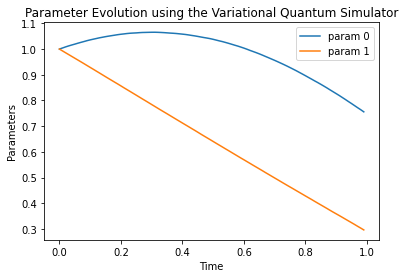

In [11]:
# Plot parameter evolution

plt.plot(dt*np.arange(Nt), lambda_k_t, label = [f"param {i}" for i in range(lambda_k_t.shape[1])])
plt.xlabel("Time")
plt.ylabel("Parameters")
plt.legend(loc="best")
plt.title("Parameter Evolution using the Variational Quantum Simulator")

We want to compare our results to the actual time evolution of the state obtained solving the Schrödinger equation. First, we need to make sure that for the initial parameters, the trial state $|\Psi (\lambda_1(0), \lambda_2(0)) \rangle$ is equivalent to the initial state for $t=0$. We will fix then as initial state for the evolution $|\Phi_s (0) \rangle$ such that

$$
|\Phi_s (0) \rangle = e^{i \lambda_1(0) H_{x}} e^{i \lambda_2(0) H_{z}} |\Phi (0) \rangle = |\Psi (\lambda_1(0), \lambda_2(0)) \rangle
$$

and the state evolution is then given by

$$
|\Phi_s (t) \rangle = e^{-i H t} |\Phi_s (0) \rangle
$$

In [12]:
initial_state_s = state_from_parameters(params_init, ops, fs, ini_state)

The Schrödinger equation is then solved numerically using the Euler's method

In [13]:
# Solve the schrodinger equation numerically

schrodinger = define_schrodinger_ode(opsH, hs)
numeric_evolution = euler(schrodinger, initial_state_s, dt, Nt)

Lastly, we compare how close are the states obtained from solving the Schrödinger equation to the states obtained through the variational algorithm using the quantum state fidelity [[4]](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states), which for pure states is given by

$$
F(|\psi\rangle, |\phi\rangle) = \left|\left\langle\psi | \phi\right\rangle\right|^{2}
$$

Then, we define the infidelity between two quantum states simply as

$$
I(|\psi\rangle, |\phi\rangle) = 1 - F(|\psi\rangle, |\phi\rangle) = 1 - \left|\left\langle\psi | \phi\right\rangle\right|^{2}
$$

As two states are equivalent up to a global phase if the infidelity between them is 0, we can say that two states are closer as  the infidelity gets lower.

Text(0.5, 1.0, 'Infidelity between the obtained state from the VQS and the Schrödinger evolution')

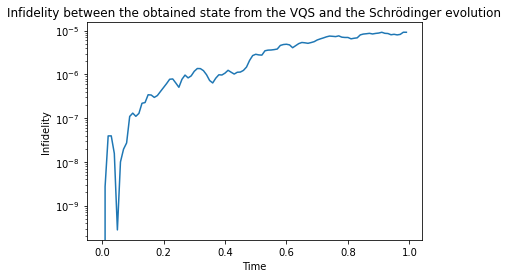

In [14]:
# From params to the state psi(lambda)

psi_lambda_t = [state_from_parameters(lambda_k_t[t], ops, fs, ini_state) for t in range(Nt)]


# Calculate infidelity from the circuit vqs with the schrodinger equation solution using matrix exponentiation

inf_array = [state_infidelity(numeric_evolution[t], psi_lambda_t[t]) for t in range(Nt)]

plt.plot(dt*np.arange(Nt), inf_array)
plt.xlabel("Time")
plt.ylabel("Infidelity")
plt.yscale("log")
plt.title("Infidelity between the obtained state from the VQS and the Schrödinger evolution")

From the above figure, it's possible to see that our algorithm successfully simulates the state evolution, achieving at worst an infidelity of the order of $10^{-5}$. For the 3 qubits simulation, refer to the `3qubits_simulation_tutorial.ipynb` notebook.

## 6.  Experiments for quantum Ising model

Finally, we performed an experiment on the ibmq_lima device with the qiskit-runtime architecture, using the same parameters as in the simulation.

In [15]:
# First, we load the experimental data

exp_lambda_k_t = np.load('data/params_2qubits_experiment.npy')

Next, we plot the parameters evolution

Text(0.5, 1.0, 'Parameter Evolution using the Variational Quantum Simulator')

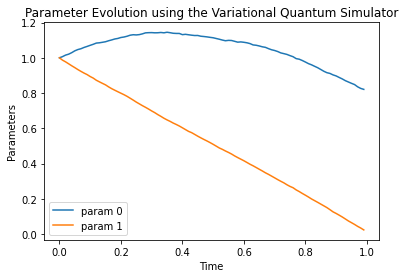

In [16]:
plt.plot(dt*np.arange(Nt), exp_lambda_k_t, label = [f"param {i}" for i in range(exp_lambda_k_t.shape[1])])
plt.xlabel("Time")
plt.ylabel("Parameters")
plt.legend(loc="best")
plt.title("Parameter Evolution using the Variational Quantum Simulator")

Then we calculate the infidelity between the state from the VQS experiment and the Schrödinger evolution, and compare it to the simulation results.

Text(0.5, 1.0, 'Infidelity between the obtained state from the VQS and the Schrödinger evolution')

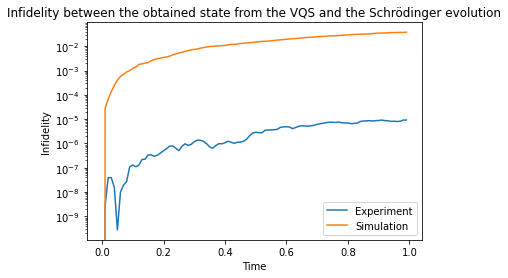

In [17]:
psi_lambda_exp_t = [state_from_parameters(exp_lambda_k_t[t], ops, fs, ini_state) for t in range(Nt)]

inf_array_exp = [state_infidelity(numeric_evolution[t], psi_lambda_exp_t[t]) for t in range(Nt)]

plt.plot(dt*np.arange(Nt), inf_array, label = "Experiment")
plt.plot(dt*np.arange(Nt), inf_array_exp, label = "Simulation")

plt.xlabel("Time")
plt.ylabel("Infidelity")
plt.yscale("log")
plt.legend()
plt.title("Infidelity between the obtained state from the VQS and the Schrödinger evolution")

Even considering the errors asociated with the quantum hardware, our algorithm is capable of correctly simulating the state evolution, achieving at worst an infidelity of the order of $10^{-2}$.

## 7. Discussion and outlook

We implemented a package using Qiskit to simulate the time evolution of quantum systems. The algorithm is of the variational type, so it can be implemented with quantum circuits of much less depth compared to the Trotter algorithm. The evolution of the state using both the simulator and the experimental results show a close agreement with the real state of the system. This is shown using the fidelity between states.

There are some improvements that could be made on the package. 
- We are currently implementing the variational forms using the Qiskit function <i>HamiltonianGate </i> applied to a string of Paulis $\sigma_k$ and a parameter $\lambda_k$. This function constructs $e^{-i \lambda_k \sigma_k}$ and decomposes it into basic gates. This is not necessarly efficient when the number of qubits is high, so we could improve this constructing variational forms that are efficient for each specific problem. 
- The same algorithm can be used to perform imaginary time evolution. This is useful to find ground states of Hamiltonians.
- We could test our package with different Hamiltonians and with a higher number of qubits.
- We could modify the parameters in the Hamiltonians to find phase transitions in the systems.

## References


[1] [Variational Method](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics))

[2] [Stationary-action principle](https://en.wikipedia.org/wiki/Stationary-action_principle)

[3] [Ising Model](https://en.wikipedia.org/wiki/Ising_model)

[4] [Fidelity of quantum states](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states)

[5] Roger Balian and Marcel Vénéroni. Static and dynamic variational principles for expectation values of observables.$\textit{ Annals of Physics}$, 187 (1988). DOI: https://doi.org/10.1016/0003-4916(88)90280-1

[6] Haegeman, Jutho and Cirac, J. Ignacio and Osborne, Tobias J. and Pižorn, Iztok and Verschelde, Henri and Verstraete, Frank. Time-Dependent Variational Principle for Quantum Lattices. $\textit{Phys. Rev. Lett.}$, 107 (2011). DOI: https://doi.org/10.1103/PhysRevLett.107.070601

[7] Yuan, X., Endo, S., Zhao, Q., Li, Y. & Benjamin, S. C. Theory of variational quantum simulation. $\textit{Quantum 3}$, 191 (2019). DOI: https://doi.org/10.22331/q-2019-10-07-191. URL:https://quantum-journal.org/papers/q-2019-10-07-191/

[8] Ying Li and Simon C. Benjamin. Efficient variational quantum simulator incorporating active error minimization. $\textit{Phys. Rev. X}$, 7:021050, Jun 2017. DOI: https://doi.org/10.1103/PhysRevX.7.021050. URL: https://link.aps.org/doi/10.1103/PhysRevX.7.021050.





